In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import torch
from tqdm import tqdm, trange

import deepinv as dinv
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing, plot_error_bars
from deepinv.models.complex import to_complex_denoiser

In [3]:
import matplotlib.font_manager as fm

# Replace with the actual path from fc-list output
font_path = "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf"
fm.fontManager.addfont(font_path)

# Number of Layers

In [15]:
# load data
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/paper/data/number_of_layers/pseudorandom")

df_1_spec = pd.read_csv(load_path / "res_pseudorandom_1_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")
df_2_spec = pd.read_csv(load_path / "res_pseudorandom_2_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")
df_3_spec = pd.read_csv(load_path / "res_pseudorandom_3_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")
df_4_spec = pd.read_csv(load_path / "res_pseudorandom_4_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")

df_1_gd_spec = pd.read_csv(load_path /"res_pseudorandom_1_gd-spectral_100repeat_10000iter_2.0284664630889893-4.983266830444336.csv")
df_2_gd_spec = pd.read_csv(load_path / "res_pseudorandom_2_gd-spectral_100repeat_10000iter_2.0284664630889893-4.983266830444336.csv")
df_3_gd_spec = pd.read_csv(load_path / "res_pseudorandom_3_gd-spectral_100repeat_10000iter_2.0284664630889893-4.983266830444336.csv")
df_4_gd_spec = pd.read_csv(load_path / "res_pseudorandom_4_gd-spectral_100repeat_10000iter_2.0284664630889893-4.983266830444336.csv")

In [16]:
df_1_spec.head()

,Unnamed: 0,oversampling_ratio,repeat0,repeat1,repeat2,repeat3,repeat4,repeat5,repeat6,repeat7,...,repeat90,repeat91,repeat92,repeat93,repeat94,repeat95,repeat96,repeat97,repeat98,repeat99
0,0,2.028466,0.011578,0.028169,0.042484,0.019128,0.036256,0.037208,0.037390,0.021961,...,0.027365,0.045563,0.036923,0.034269,0.034026,0.030932,0.037097,0.035328,0.027185,0.035527
1,1,2.086420,0.038569,0.032981,0.037047,0.040947,0.039530,0.037445,0.008110,0.053334,...,0.026409,0.033235,0.030683,0.028746,0.043040,0.016082,0.037541,0.042598,0.035096,0.032234
2,2,2.145189,0.039947,0.041595,0.034346,0.041885,0.034915,0.030923,0.023297,0.036551,...,0.028358,0.027299,0.035024,0.026816,0.038148,0.035797,0.031991,0.035976,0.038472,0.032677
3,3,2.204775,0.027120,0.038935,0.029568,0.034458,0.028864,0.022657,0.031825,0.040256,...,0.037026,0.032563,0.030456,0.048023,0.034683,0.033991,0.027102,0.021503,0.036824,0.044313
4,4,2.265177,0.031514,0.034536,0.041446,0.033679,0.044497,0.036083,0.029360,0.042056,...,0.036046,0.040957,0.030051,0.042978,0.033044,0.031706,0.037950,0.038470,0.037372,0.041064


In [17]:
for df in [df_1_spec,df_1_gd_spec,df_2_spec,df_2_gd_spec,df_3_spec,df_3_gd_spec,df_4_spec,df_4_gd_spec]:
    rows_to_drop = []
    left = 1.8
    for index, row in df.iterrows():
        if row["oversampling_ratio"] - left < 0.2:
            rows_to_drop.append(index)
        else:
            left = row["oversampling_ratio"]
    df.drop(rows_to_drop, inplace=True) 

In [18]:
oversampling_ratios = df_1_spec["oversampling_ratio"]

1 layer spec
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) 1 layer spec
1 layer gd spec
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) 1 layer gd spec
2 layers spec
(1.0, 0.4980392156862745, 0.054901960784313725) 2 layers spec
2 layers gd spec
(1.0, 0.4980392156862745, 0.054901960784313725) 2 layers gd spec
3 layers spec
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) 3 layers spec
3 layers gd spec
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) 3 layers gd spec
4 layers spec
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) 4 layers spec
4 layers gd spec
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) 4 layers gd spec
Figure saved to layers.svg


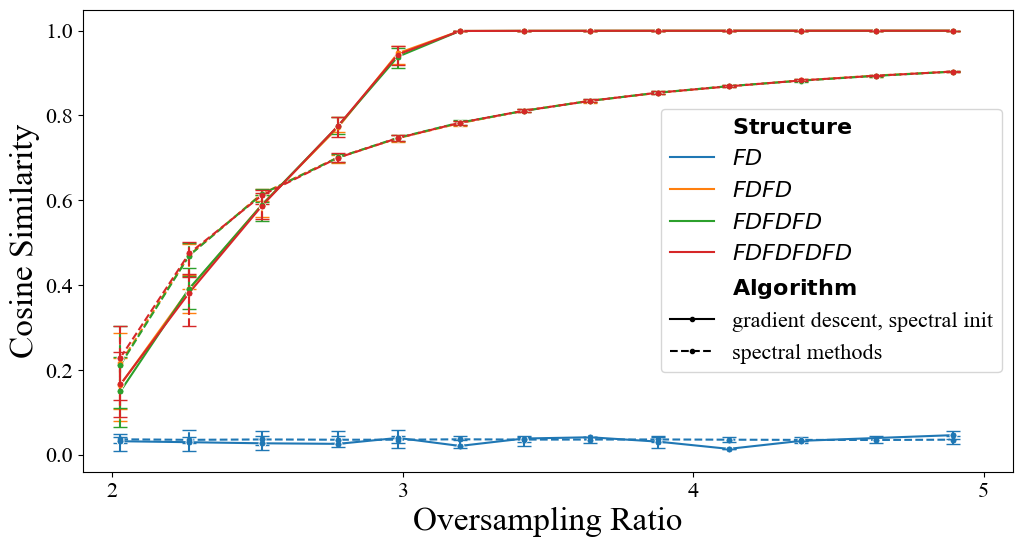

In [20]:
# plot
plot_error_bars([oversampling_ratios]*8,
                [df_1_spec,df_1_gd_spec,df_2_spec,df_2_gd_spec,df_3_spec,df_3_gd_spec,df_4_spec,df_4_gd_spec],
                ["1 layer spec","1 layer gd spec","2 layers spec","2 layers gd spec","3 layers spec","3 layers gd spec","4 layers spec","4 layers gd spec"],
                #title="Performance Comparison of Different Number of Layers",
                #save="layers_gd_spec.svg",
                figsize=(12,6),
                plot="layer",
                xlim=(1.9,5.1),
                xticks=[2,3,4,5],
                legend_loc="center right",
                labelsize=24,
                fontsize=16,
                save='layers.svg')

# plot reconstruction comparison

torch.Size([1, 1, 99, 99])


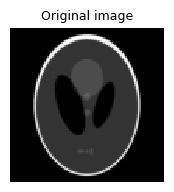

In [4]:
# generate signal
img_size = 128
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
print(x.shape)
plot(x, titles="Original image")

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [5]:
# create 3 models with different oversampling: 2.0, 2.5, 3.0

output_sizes = {1:141, 2:157, 3:173}
recons = [x]

def spectral_methods_wrapper(y, physics, **kwargs):
    x = spectral_methods(y, physics, n_iter=5000, **kwargs)
    z = spectral_methods(y, physics, n_iter=5000, **kwargs)
    return {"est": (x, z)}

for i in range(1,4):
    physics = dinv.physics.PseudoRandomPhaseRetrieval(
        n_layers=2,
        input_shape=(1, img_size, img_size),
        output_shape=(1, output_sizes[i], output_sizes[i]),
        drop_tail=True,
        shared_weights=True,
        dtype = torch.cfloat,
        device=device,
    )

    y = physics.forward(x_phase)

    params_algo = {"stepsize": 3e-3*physics.oversampling_ratio.item(), "g_params": 0.00}

    model = optim_builder(
        iteration="PGD",
        prior=dinv.optim.prior.Zero(),
        data_fidelity=dinv.optim.data_fidelity.L2(),
        early_stop=True,
        max_iter=20000,
        verbose=False,
        params_algo=params_algo,
        custom_init=spectral_methods_wrapper,
    )

    x_phase_recon = model(y, physics, x_gt=x_phase)
    x_phase_recon = correct_global_phase(x_phase_recon,x_phase)
    x_recon = torch.angle(x_phase_recon) / (2*torch.pi) + 0.5
    recons.append(x_recon)

Image 0, channel 0 does not have a global phase shift.
Image 0, channel 0 does not have a global phase shift.
Image 0, channel 0 does not have a global phase shift.


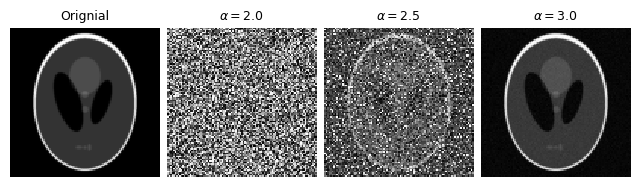

In [6]:
# visuliazation
plot(recons, titles=["Orignial",r"$\alpha=2.0$", r"$\alpha=2.5$", r"$\alpha=3.0$"],save="recons.svg")

# Reconstruction Accuracy

In [4]:
df_random_gd_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240806-155843/random/res_random_gd_spectral_100repeat_10000iter_0.10000000149011612-9.0.csv")
df_random_gd_spec_small = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240808-102025/random/res_random_gd_spectral_100repeat_10000iter_2.0-2.5999999046325684.csv")
df_random_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240806-155124/random/res_random_spectral_100repeat_5000iter_0.10000000149011612-9.0.csv")
df_random_gd_rand = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240809-085658/random/res_random_gd_random_100repeat_10000iter_0.10000000149011612-9.0.csv")
df_pseudorandom_gd_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/data/pseudorandom/res_pseudorandom_gd_spectral_100repeat_10000iter_0.0001020304043777287-9.0.csv")
df_pseudorandom_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240809-192806/pseudorandom/res_pseudorandom_2_spectral_100repeat_5000iter_0.0009765625-9.0.csv")
df_pseudorandom_gd_rand = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240809-193549/pseudorandom/res_pseudorandom_2_gd-rand_100repeat_10000iter_0.0009765625-9.0.csv")

In [5]:
df_pseudorandom_gd_spec.head(n=15)

,Unnamed: 0,oversampling_ratio,step_size,repeat0,repeat1,repeat2,repeat3,repeat4,repeat5,repeat6,...,repeat90,repeat91,repeat92,repeat93,repeat94,repeat95,repeat96,repeat97,repeat98,repeat99
0,0,0.000102,tensor(1.0203e-08),0.006197,0.012924,0.015086,0.015219,0.013591,0.008954,0.003601,...,0.008429,0.014861,0.006377,0.003940,0.002864,0.002242,0.009766,0.008999,0.011438,0.005406
1,1,0.000918,tensor(9.1827e-08),0.008899,0.015888,0.020724,0.013600,0.020286,0.015155,0.015168,...,0.019759,0.017080,0.022019,0.016170,0.021891,0.019471,0.012672,0.013885,0.017568,0.018706
2,2,0.002551,tensor(2.5508e-07),0.018524,0.017262,0.022666,0.019067,0.031068,0.022795,0.023934,...,0.017820,0.019633,0.019443,0.023986,0.022369,0.017013,0.013389,0.024820,0.021483,0.019479
3,3,0.004999,tensor(4.9995e-07),0.022359,0.020651,0.021641,0.021114,0.019848,0.016866,0.013436,...,0.019208,0.018436,0.019472,0.022639,0.020062,0.019698,0.020464,0.021434,0.023035,0.024112
4,4,0.008264,tensor(8.2645e-07),0.018207,0.019094,0.025640,0.020829,0.020971,0.023619,0.025043,...,0.026003,0.027013,0.022504,0.021637,0.022897,0.022488,0.022028,0.021703,0.025270,0.017039
5,5,0.012346,tensor(1.2346e-06),0.026692,0.035359,0.021565,0.020203,0.018828,0.018979,0.020852,...,0.023761,0.022217,0.023945,0.024347,0.023582,0.027237,0.020232,0.024082,0.023079,0.025841
6,6,0.017243,tensor(1.7243e-06),0.022467,0.022055,0.019902,0.026146,0.026098,0.016490,0.024148,...,0.027027,0.022028,0.023132,0.016527,0.020730,0.019150,0.024438,0.023651,0.020966,0.022262
7,7,0.022957,tensor(2.2957e-06),0.028232,0.024056,0.030848,0.024508,0.024938,0.022429,0.028631,...,0.017839,0.021610,0.026549,0.023493,0.022350,0.013730,0.022707,0.004717,0.020599,0.023670
8,8,0.029487,tensor(2.9487e-06),0.029224,0.022867,0.024187,0.021787,0.025196,0.032576,0.023795,...,0.026126,0.027105,0.022243,0.021878,0.020872,0.025839,0.021849,0.022460,0.027384,0.026832
9,9,0.036833,tensor(3.6833e-06),0.026895,0.026652,0.027346,0.026454,0.029778,0.014463,0.030035,...,0.032707,0.027972,0.029036,0.026331,0.031496,0.019142,0.024794,0.023706,0.023501,0.027853


In [6]:
for oversampling_ratio in [2.0,2.1,2.2,2.3,2.4,2.5,2.6]:
    df_random_gd_spec.loc[df_random_gd_spec["oversampling_ratio"] == oversampling_ratio] = df_random_gd_spec_small.loc[df_random_gd_spec_small["oversampling_ratio"] == oversampling_ratio].values

In [7]:
1.0 % 0.2

0.19999999999999996

In [8]:
for df in [df_random_gd_spec, df_random_spec, df_random_gd_rand]:
    rows_to_drop = []
    for index, row in df.iterrows():
        if round(row['oversampling_ratio']*10) % 2 != 0 and row['oversampling_ratio']< 3.0:
            rows_to_drop.append(index)

    df.drop(rows_to_drop, inplace=True)

In [9]:
for df in [df_pseudorandom_gd_rand, df_pseudorandom_gd_spec, df_pseudorandom_spec]:
    rows_to_drop = []
    left = -0.15
    for index, row in df.iterrows():
        if row["oversampling_ratio"] - left < 0.2:
            rows_to_drop.append(index)
        else:
            left = row["oversampling_ratio"]
    df.drop(rows_to_drop, inplace=True) 

In [10]:
oversampling_ratios_random_gd_spec = df_random_gd_spec["oversampling_ratio"]
oversampling_ratios_random_spec = df_random_spec["oversampling_ratio"]
oversampling_ratios_random_gd_rand = df_random_gd_rand["oversampling_ratio"]
oversampling_ratios_pseudorandom_gd_spec = df_pseudorandom_gd_spec["oversampling_ratio"]
oversampling_ratios_pseudorandom_spec = df_pseudorandom_spec["oversampling_ratio"]
oversampling_ratios_pseudorandom_gd_rand = df_pseudorandom_gd_rand["oversampling_ratio"]

In [11]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

iid gd spec
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid gd spec
iid spec
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid spec
iid gd rand
(0.12156862745098039, 0.47058823529411764, 0.7058823529411765) iid gd rand
structured gd spec
(1.0, 0.4980392156862745, 0.0) structured gd spec
structured spec
(1.0, 0.4980392156862745, 0.0) structured spec
structured gd rand
(1.0, 0.4980392156862745, 0.0) structured gd rand


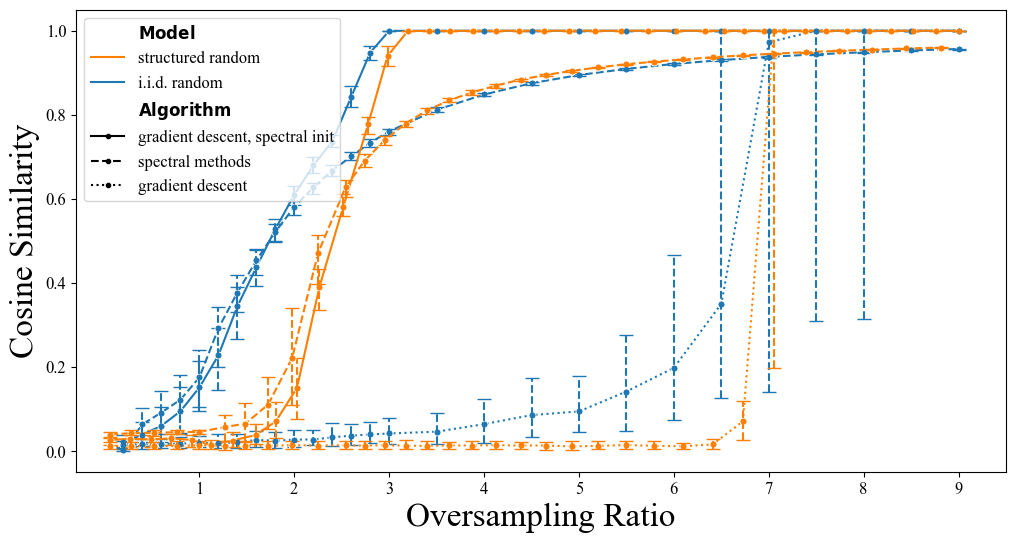

In [12]:
plot_error_bars([oversampling_ratios_random_gd_spec,
                 oversampling_ratios_random_spec,oversampling_ratios_random_gd_rand,oversampling_ratios_pseudorandom_gd_spec,oversampling_ratios_pseudorandom_spec,
                 oversampling_ratios_pseudorandom_gd_rand],
                [df_random_gd_spec,
                 df_random_spec,
                 df_random_gd_rand,
                 df_pseudorandom_gd_spec,
                 df_pseudorandom_spec,
                 df_pseudorandom_gd_rand],
                ['iid gd spec',
                 'iid spec',
                 'iid gd rand',
                 'structured gd spec',
                 'structured spec',
                 'structured gd rand'],
                figsize=(12,6),
                font="Times New Roman",
                fontsize=12,
                labelsize=24,
                xlim=(-0.3,9.5),
                error_bar_linestyle="--",
                structured_color=sns.color_palette("Paired")[7],
                iid_color=sns.color_palette("Paired")[1],
                show=False,
                save='recon.svg')

# Weak Recovery Threshold

In [49]:
df_random_spec = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/paper/runs/20240807-154721/random/res_random_spectral_128size_100repeat_5000iter_0.10000000149011612-2.0.csv")
oversampling_ratios = df_random_spec["oversampling_ratio"]

spec


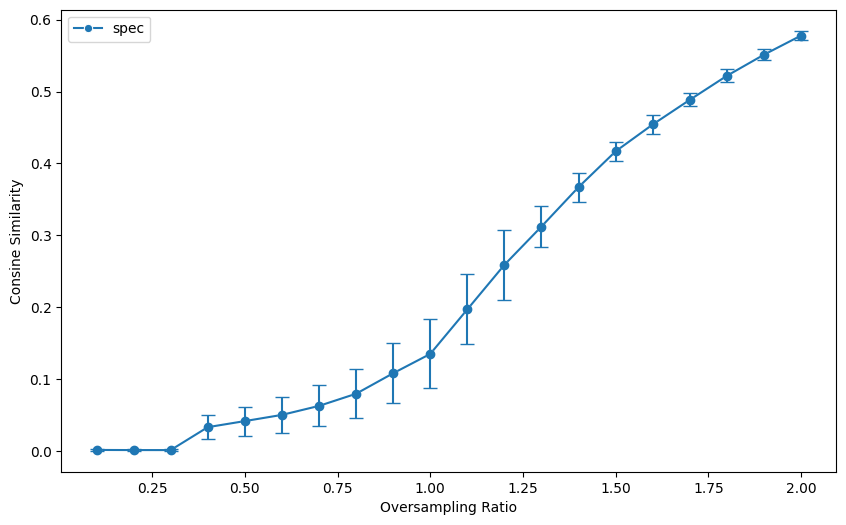

In [50]:
plot_error_bars([oversampling_ratios], [df_random_spec], ['spec'])

# Time Complexity

In [4]:
df_random_cpu = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/df_random_cpu.csv")
df_random_gpu = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/df_random_gpu.csv")
df_pseudorandom_cpu = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/df_pseudorandom_cpu.csv")
df_pseudorandom_gpu = pd.read_csv("/home/zhhu/workspaces/deepinv/experimental/df_pseudorandom_gpu.csv")

In [5]:
df_random_gpu.iloc[0]["img_size_8"] = None
df_random_gpu

/tmp/ipykernel_712692/1141376657.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_random_gpu.iloc[0]["img_size_8"] = None


,img_size_8,img_size_16,img_size_32,img_size_64,img_size_96,img_size_128,img_size_160,img_size_192,img_size_224,img_size_240
0,NaN,0.000501,0.000638,0.000540,0.001046,0.003431,0.007872,0.016202,0.029026,0.031205
1,0.000252,0.000467,0.000466,0.000386,0.001200,0.003330,0.007773,0.016022,0.023464,0.031089
2,0.000179,0.000460,0.000462,0.000367,0.001196,0.003243,0.007803,0.016826,0.023490,0.031042
3,0.000170,0.000459,0.000453,0.000364,0.001208,0.003246,0.007780,0.016126,0.023477,0.031130
4,0.000168,0.000459,0.000451,0.000364,0.001168,0.003349,0.007809,0.015985,0.023582,0.031191
...,...,...,...,...,...,...,...,...,...,...
95,0.000164,0.000173,0.000174,0.000299,0.001241,0.003373,0.007748,0.016134,0.023584,0.031102
96,0.000164,0.000172,0.000170,0.000296,0.001233,0.003400,0.007826,0.016018,0.023588,0.030983
97,0.000164,0.000172,0.000168,0.000296,0.001230,0.003401,0.007770,0.016045,0.023482,0.031095
98,0.000165,0.000174,0.000168,0.000297,0.001246,0.003392,0.007826,0.015952,0.023474,0.031016


In [6]:
img_sizes: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
num_pixels = [img_size**2 for img_size in img_sizes]

i.i.d. random (CPU)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) i.i.d. random (CPU)
i.i.d. random (GPU)
(1.0, 0.4980392156862745, 0.054901960784313725) i.i.d. random (GPU)
structured random (CPU)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) structured random (CPU)
structured random (GPU)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) structured random (GPU)
Figure saved to time.svg


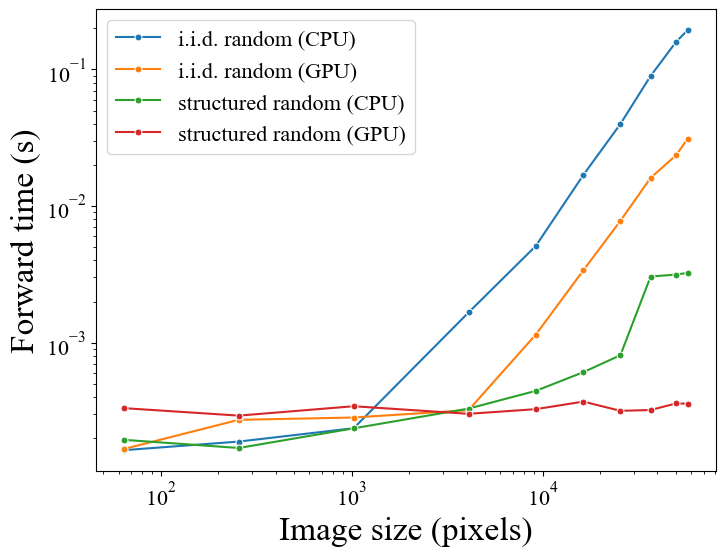

In [13]:
plot_error_bars([num_pixels]*4,
                [df_random_cpu,df_random_gpu,df_pseudorandom_cpu,df_pseudorandom_gpu],
                ['i.i.d. random (CPU)','i.i.d. random (GPU)','structured random (CPU)','structured random (GPU)'],
                axis=0,
                figsize=(8,6),
                xscale='log',
                yscale='log',
                xlabel='Image size (pixels)',
                ylabel='Forward time (s)',
                legend_loc='upper left',
                plot='time',
                error_bar='std',
                save='time.svg',
                fontsize=16,
                labelsize=24)